In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import os


In [5]:
df = pd.read_csv(r'C:\Users\ss6365\Desktop\location_privacy_final\collected\machine_learning\attack1\laplace\200\merged_laplace_0.1_encoded_200.csv')
df

,longitude,latitude,identifier,perturbed_latitude,perturbed_longitude,lat_bin,lon_bin,location_id
0,-77.680333,43.083838,1.0,43.083840,-77.680344,97,66,19467
1,-77.680991,43.083803,1.0,43.083827,-77.681023,97,62,19463
2,-77.681017,43.083802,1.0,43.083831,-77.680987,97,62,19463
3,-77.681042,43.083802,1.0,43.083767,-77.681051,97,62,19463
4,-77.681090,43.083802,1.0,43.083803,-77.681167,97,62,19463
...,...,...,...,...,...,...,...,...
55420,-77.680445,43.083879,46.0,43.083866,-77.680440,98,65,19666
55421,-77.680442,43.083868,46.0,43.083876,-77.680448,98,65,19666
55422,-77.680441,43.083863,46.0,43.083831,-77.680385,98,65,19666
55423,-77.680442,43.083860,46.0,43.083824,-77.680429,98,65,19666


In [6]:
df['identifier'].nunique()

36

In [7]:
features

NameError: name 'features' is not defined

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np



def knn_rule(data , strategy_ln = True, weights_f = 'uniform', metrics = 'manhattan', points_per_trace = 1):

    features = data[['perturbed_latitude', 'perturbed_longitude']]
    labels = data['location_id']

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    features_scaled_df = pd.DataFrame(features_scaled, columns=['perturbed_latitude', 'perturbed_longitude'])

    X_train, X_test, y_train, y_test, identifiers_train, identifiers_test = train_test_split(
                                            features_scaled_df, labels, data['identifier'], test_size=0.2
                                            )

    if strategy_ln:
        k = round(np.log(len(X_train)))
    else:
        k = round(np.log10(len(X_train)))
    #weights_f = 'distance', 'uniform'
    #metrics = manhattan, ‘euclidean’, ‘haversine’, ‘cosine’

    knn = KNeighborsClassifier(n_neighbors=k)    

    knn.fit(X_train, y_train)

    
    
    # Create a DataFrame for easier manipulation
    test_df = pd.DataFrame(X_test, columns=['perturbed_latitude', 'perturbed_longitude'])
    test_df['identifier'] = identifiers_test.values
    test_df['true_label'] = y_test.values
    
    trace_accuracies = []
    
    for identifier, group in test_df.groupby('identifier'):
        # Select a subset of the group based on points_per_trace
        subset = group.head(points_per_trace)
        # Predict the subset
        y_pred = knn.predict(subset[['perturbed_latitude', 'perturbed_longitude']])
        # Calculate accuracy for this subset
        accuracy = np.mean(y_pred == subset['true_label'])
        trace_accuracies.append(accuracy)

    overall_trace_accuracy = np.mean(trace_accuracies)

    return 1-overall_trace_accuracy

# Load the data



In [115]:
data =  pd.read_csv(r'C:\Users\ss6365\Desktop\location_privacy_final\collected\machine_learning\attack1\laplace\200\merged_laplace_0.1_encoded_200.csv')
knn_rule(data , strategy_ln = True, weights_f = 'uniform', metrics = 'manhattan', points_per_trace = 4)

0.22916666666666663

In [142]:
def all_directory_knn(file_directory, strategy_ln = True, weights_f = 'uniform', metrics = 'manhattan', num_runs = 1, points_per_trace = 1):

    all_files = os.listdir(file_directory)
    csv_files = [file for file in all_files if file.endswith('.csv')]

    bayes_risks = [0] * len(csv_files)
    
    for _ in range(num_runs):

        for idx, file_name in enumerate(csv_files):

            file_path = os.path.join(file_directory, file_name)
            data = pd.read_csv(file_path)

            bayes_risk = knn_rule(data , strategy_ln = True, weights_f = 'uniform', metrics = 'manhattan', points_per_trace = 1)
            bayes_risks[idx] += bayes_risk
            

    bayesRisk_avg = [x / num_runs for x in bayes_risks]

    return bayesRisk_avg

In [162]:
file_directory = r'C:\Users\ss6365\Desktop\picasso\data\collected\200\1'
a=all_directory_knn(file_directory, strategy_ln = True, weights_f = 'distance', metrics = 'euclidean', num_runs = 100, points_per_trace = 1)
a

[0.06757142857142852]

In [133]:
file_directory = r'C:\Users\ss6365\Desktop\picasso\data\collected\200\0.1'
a=all_directory_knn(file_directory, strategy_ln = True, weights_f = 'distance', metrics = 'euclidean', num_runs = 100, points_per_trace = 2)
a

[0.2177777777777777]

In [39]:
file_directory = r'C:\Users\ss6365\Desktop\picasso\data'
a=all_directory_knn(file_directory, strategy_ln = True, weights_f = 'distance', metrics = 'euclidean', num_runs = 100, points_per_trace = 3)
a

[0.2236111111111111]

In [40]:
file_directory = r'C:\Users\ss6365\Desktop\picasso\data'
a=all_directory_knn(file_directory, strategy_ln = True, weights_f = 'distance', metrics = 'euclidean', num_runs = 100, points_per_trace = 10)
a

[0.20499999999999993]

In [49]:
def bayes_risk_trace(file_directory, strategy_ln = True, weights_f = 'distance', metrics = 'euclidean', num_runs = 1, trace = 10):

    bayes_trace = []

    for i in range(trace):
        bayes = all_directory_knn(file_directory, strategy_ln = True, weights_f = 'distance', metrics = 'euclidean', num_runs = 1, points_per_trace = i+1)
        
        bayes_trace.append(bayes)
    flattened_list = [item for sublist in bayes_trace for item in sublist]    
    return flattened_list 

In [53]:
file_directory = r'C:\Users\ss6365\Desktop\picasso\data'
bayes_risk_trace(file_directory, strategy_ln = True, weights_f = 'distance', metrics = 'euclidean', num_runs = 1, trace = 5)

[0.3055555555555556,
 0.2222222222222222,
 0.2222222222222222,
 0.2777777777777778,
 0.2222222222222222]

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import StandardScaler
# from itertools import islice

# def sliding_window(seq, n=2):
#     "Returns a sliding window (of width n) over data from the iterable"
#     it = iter(seq)
#     result = tuple(islice(it, n))
#     if len(result) == n:
#         yield result
#     for elem in it:
#         result = result[1:] + (elem,)
#         yield result

# def knn_rule(data, strategy_ln=True, weights_f='uniform', metrics='manhattan', points_per_trace=1):
#     # Prepare features and labels
#     features = data[['perturbed_latitude', 'perturbed_longitude']]
#     labels = data['location_id']

#     # Scale the features
#     scaler = StandardScaler()
#     features_scaled = scaler.fit_transform(features)
#     features_scaled_df = pd.DataFrame(features_scaled, columns=['perturbed_latitude', 'perturbed_longitude'])

#     # Split the data into training and testing sets
#     X_train, X_test, y_train, y_test, identifiers_train, identifiers_test = train_test_split(
#         features_scaled_df, labels, data['identifier'], test_size=0.3, random_state=None
#     )

#     # Determine k using logarithmic strategy
#     if strategy_ln:
#         k = round(np.log(len(X_train)))
#     else:
#         k = round(np.log10(len(X_train)))

#     # Initialize and train the k-NN classifier
#     knn = KNeighborsClassifier(n_neighbors=k, weights=weights_f, metric=metrics, n_jobs=-1)
#     knn.fit(X_train, y_train)

#     # Create a DataFrame for easier manipulation of test data
#     test_df = pd.DataFrame(X_test, columns=['perturbed_latitude', 'perturbed_longitude'])
#     test_df['identifier'] = identifiers_test.values
#     test_df['true_label'] = y_test.values

#     # Evaluate trace accuracy using a sliding window approach
#     trace_accuracies = []
#     for identifier, group in test_df.groupby('identifier'):
#         group_list = group.to_dict('records')  # Convert group to list of dicts for sliding window
#         for subset in sliding_window(group_list, points_per_trace):
#             subset_df = pd.DataFrame(subset)  # Convert each window to DataFrame
#             y_pred = knn.predict(subset_df[['perturbed_latitude', 'perturbed_longitude']])
#             accuracy = np.mean(y_pred == subset_df['true_label'])
#             trace_accuracies.append(accuracy)

#     # Calculate and return the overall trace-based error rate
#     overall_trace_accuracy = np.mean(trace_accuracies)
#     return 1 - overall_trace_accuracy

# # Load the data
# data = pd.read_csv(r'C:\Users\ss6365\Desktop\location_privacy_final\collected\machine_learning\attack1\laplace\200\merged_laplace_0.1_encoded_200.csv')
# # Run the KNN rule with specific parameters
# error_rate = knn_rule(data, strategy_ln=True, weights_f='uniform', metrics='manhattan', points_per_trace=7)
# print(f"Overall Trace-Based Error Rate: {error_rate}")


In [55]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

def trace_based_attack(data, points_per_trace=1):
    
    features = data[['perturbed_latitude', 'perturbed_longitude']]
    labels = data['location_id']

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    features_scaled_df = pd.DataFrame(features_scaled, columns=['perturbed_latitude', 'perturbed_longitude'])

    X_train, X_test, y_train, y_test, identifiers_train, identifiers_test = train_test_split(
        features_scaled_df, labels, data['identifier'], test_size=0.3, random_state=None
    )
    # Assuming data preparation and scaling are done
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(X_train, y_train)
    
    traces = data.groupby('identifier')
    final_predictions = []
    
    for trace_id, points in traces:
        probabilities = np.zeros((len(points), len(classifier.classes_)))
        
        for i, point in enumerate(points):
            current_proba = classifier.predict_proba([point.features])[0]
            if i == 0:
                probabilities[i, :] = current_proba
            else:
                # Combine probabilities: here simply averaging with previous
                probabilities[i, :] = (probabilities[i-1, :] + current_proba) / 2
            
            # Normalize probabilities
            probabilities[i, :] /= np.sum(probabilities[i, :])
            
            # Predict using the maximum probability
            prediction = classifier.classes_[np.argmax(probabilities[i, :])]
            final_predictions.append((trace_id, point.index, prediction))
    
    return final_predictions

# Example usage
# data should be preprocessed to include features and grouped by 'identifier'
df = pd.read_csv(r'C:\Users\ss6365\Desktop\location_privacy_final\collected\machine_learning\attack1\laplace\200\merged_laplace_0.1_encoded_200.csv')
final_predictions = trace_based_attack(df)


AttributeError: 'str' object has no attribute 'features'

In [75]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import os
def process_directory(file_path, points_per_trajectory=2, num_runs=1, strategy='ln'):
    data = pd.read_csv(file_path)
    X = data[['perturbed_latitude', 'perturbed_longitude']]
    y = data['location_id']

    total_accuracy = 0
    total_bayes = 0

    for run in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        if strategy == 'ln':
            k = round(np.log(len(X_train)))
        elif strategy == 'log':
            k = round(math.log(len(X_train), 10))
        else:
            k = 5  # Default k value if no strategy matches

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        correct_predictions = 0
        total_predictions = 0

        for i in range(0, len(X_test), points_per_trajectory):
            prev_probs = None
            for j in range(points_per_trajectory):
                if i + j < len(X_test):
                    current_instance = X_test.iloc[[i + j]]
                    current_probs = knn.predict_proba(current_instance)[0]

                    if prev_probs is not None:
                        combined_probs = (prev_probs + current_probs) / 2
                        combined_probs /= np.sum(combined_probs)
                    else:
                        combined_probs = current_probs

                    predicted_class = knn.classes_[np.argmax(combined_probs)]
                    if predicted_class == y_test.values[i + j]:
                        correct_predictions += 1
                    prev_probs = combined_probs
                    total_predictions += 1

        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        bayes = 1 - accuracy
        total_accuracy += accuracy
        total_bayes += bayes

    average_bayes = total_bayes / num_runs
    return average_bayes


In [78]:
file_path = r'C:\Users\ss6365\Desktop\picasso\data\collected\200\0.1\merged_laplace_0.1_encoded_200.csv'
p=process_directory(file_path, points_per_trajectory=2, num_runs=1, strategy='ln')
p

0.3820478123590437

In [156]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



def process_directory(file_path, points_per_trajectory=1, num_runs=10, strategy = 'ln'):
    # Load data
    data = pd.read_csv(file_path)

    # Assume 'perturbed_latitude' and 'perturbed_longitude' are features
    # 'location_id' is the target
    X = data[['perturbed_latitude', 'perturbed_longitude']]
    y = data['location_id']
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(X)

    features_scaled_df = pd.DataFrame(features_scaled, columns=['perturbed_latitude', 'perturbed_longitude'])

    # Variables to store total accuracy and Bayes risk across all runs
    total_accuracy = 0
    total_bayes = 0

    for run in range(num_runs):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(features_scaled_df, y, test_size=0.2)  # Change random state each time
        
        if strategy == 'ln':
            k = round(np.log(len(X_train)))
        if strategy == 'log':
            k = round(math.log(len(X_train), 10))

        knn = KNeighborsClassifier(n_neighbors=k)
        # Initialize and train KNN

        knn.fit(X_train, y_train)

        # Evaluate trajectories
        correct_predictions = 0
        total_predictions = 0

        for i in range(0, len(X_test), points_per_trajectory):
            prev_probs = None
            for j in range(points_per_trajectory):
                if i + j < len(X_test):
                    current_instance = X_test.iloc[[i + j]]
                    current_probs = knn.predict_proba(current_instance)[0]

                    if prev_probs is not None:
                        weights = np.array([0.6, 0.4])  # Adjust weights as necessary
                        combined_probs = weights[0] * prev_probs + weights[1] * current_probs
                        combined_probs /= np.sum(combined_probs)
                    else:
                        combined_probs = current_probs

                    predicted_class = knn.classes_[np.argmax(combined_probs)]
                    if predicted_class == y_test.values[i + j]:
                        correct_predictions += 1
                    prev_probs = combined_probs
                    total_predictions += 1

        # Calculate accuracy for this run
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        bayes = 1 - accuracy

        total_accuracy += accuracy
        total_bayes += bayes

    # Calculate average accuracy and Bayes risk
    average_accuracy = total_accuracy / num_runs
    average_bayes = total_bayes / num_runs

    #print("Average Accuracy:", average_accuracy)
    #print("Average Bayes Risk:", average_bayes)

    return  average_bayes

In [161]:
file_path = r'C:\Users\ss6365\Desktop\picasso\data\collected\400\0.1\merged_laplace_0.1_encoded_400.csv'
p=process_directory(file_path, points_per_trajectory=5, num_runs=1, strategy = 'ln')
p

0.5850248082995038

In [196]:
bayes_list_laplace_ln_collected=[
 0.28173207036535863,
 0.21632837167343255,
 0.17843933243121335,
 0.159765448804691,
 0.14542174109156514,
 0.13513757329724851,
 0.12728912945421744,
 0.12061344158773113,
 0.11790708164185837]


bayes_list_laplace_ln_collected_baseline=[
 0.28573207036535863,
 0.28173207036535863,
 0.27673207036535863,
 0.28173207036535863,
 0.28173207036535863,
 0.28573207036535863,
 0.28173207036535863,
 0.27173207036535863,
 0.27173207036535863,]

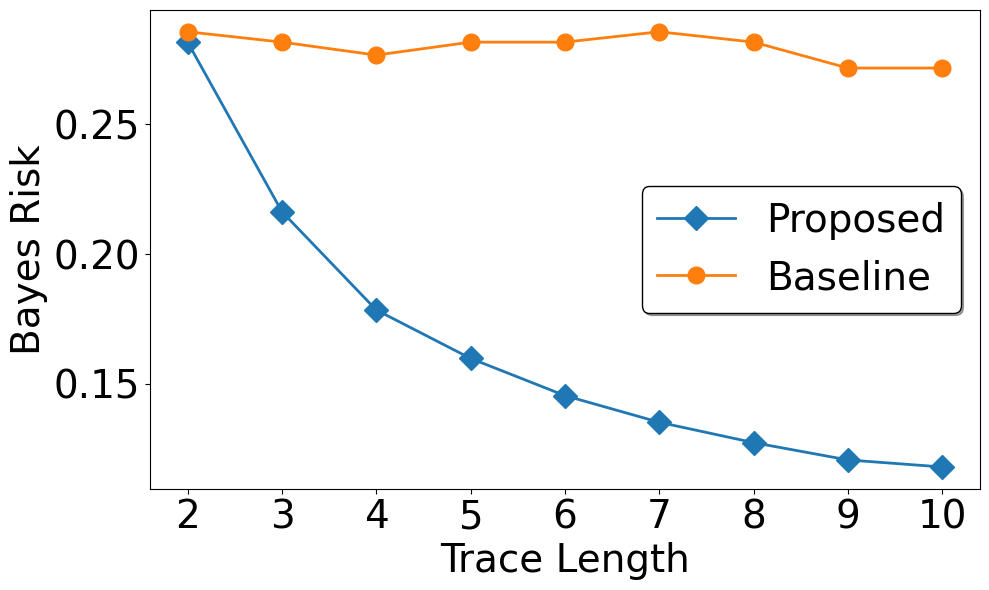

In [224]:
import matplotlib.pyplot as plt

# Example data (assuming you have these data frames ready)
epsilon_values = [2, 3, 4, 5, 6, 7, 8, 9,10]




# Define lines with linestyle added
line1 = {'x': epsilon_values, 'y': bayes_list_laplace_ln_collected, 'label': 'Proposed', 'color': '#1F77B4', 'marker': 'D', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
line2 = {'x': epsilon_values, 'y': bayes_list_laplace_ln_collected_baseline, 'label': 'Baseline', 'color': '#FF7F0E', 'marker': 'o', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
#line3 = {'x': epsilon_values, 'y': bayes_list_our_ln_tdrive, 'label': 'PSM-I$(r_b=50, \delta=5)$', 'color': '#2CA02C', 'marker': 'X', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
#line4 = {'x': epsilon_values, 'y': df_laplace_delta_ln_200_collected['Bayes security measure'], 'label': r'PLM$_{\delta}\,(\delta=5)$', 'color': '#DC143C', 'marker': '*', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}

plt.figure(figsize=(10, 6))

# Plot each line with improved settings
for line in [line1, line2]:
    plt.plot(line['x'], line['y'], label=line['label'], color=line['color'], marker=line['marker'], linestyle=line['linestyle'], linewidth=line['linewidth'], markersize=line['markersize'])

# Labels for axes
plt.xlabel('Trace Length', fontsize=28)
plt.ylabel('Bayes Risk', fontsize=28)

# Log scale for x-axis and setting specific ticks and labels
#plt.xscale('log')
plt.xticks(epsilon_values, labels=[str(val) for val in epsilon_values])
plt.tick_params(axis='both', which='major', labelsize=28)

# Adding a grid, legend, and ensuring layout is tight for best appearance
#plt.grid(True)
plt.legend(fontsize=28, frameon=True,shadow=True, loc='best').get_frame().set_edgecolor('black')

plt.tight_layout()

# Uncomment the following lines to save the plot if needed
# plt.savefig('/path/to/your/directory/filename.png', dpi=300, bbox_inches='tight')
# plt.savefig('/path/to/your/directory/filename.svg', format='svg', bbox_inches='tight')

# pathpng = r'C:\Users\ss6365\Desktop\location_privacy_final\tdrive\figure\png\tdrive_bayes_point_ln_200_tracelength.png'
# plt.savefig(pathpng, dpi=300, bbox_inches='tight')

pathsvg = r'C:\Users\ss6365\Desktop\picasso\image\svg\collected_bayes_point_ln_200_tracelength.svg'

plt.savefig(pathsvg, format='svg', bbox_inches='tight')
# Display the plot
plt.show()


In [209]:
bayes_list_laplace_ln_geolife=[
 0.37097214417596536,
 0.33424580557116484,
 0.31129485429878784,
 0.29616280003211043,
 0.28761339006181263,
 0.2807899173155655,
 0.27541141526852375,
 0.2714578148831982,
 0.26811832704503497]

bayes_list_laplace_ln_geolife_baseline=[
 0.37597214417596536,
 0.37297214417596536,
 0.37597214417596536,
 0.37497214417596536,
0.37397214417596536,
 0.37297214417596536,
 0.37497214417596536,
 0.37597214417596536,
0.37237214417596536]

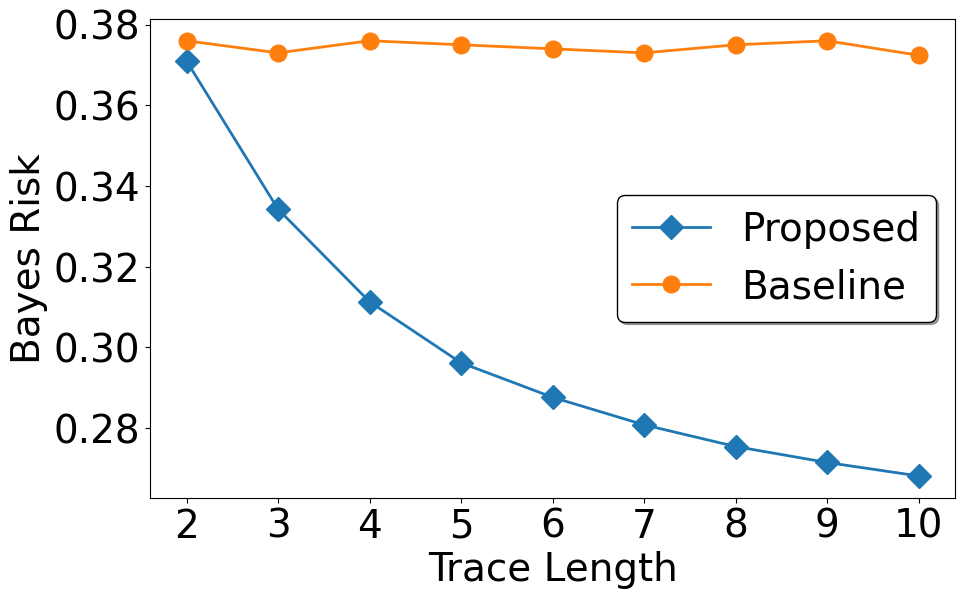

In [225]:
import matplotlib.pyplot as plt

# Example data (assuming you have these data frames ready)
epsilon_values = [2, 3, 4, 5, 6, 7, 8, 9,10]




# Define lines with linestyle added
line1 = {'x': epsilon_values, 'y': bayes_list_laplace_ln_geolife, 'label': 'Proposed', 'color': '#1F77B4', 'marker': 'D', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
line2 = {'x': epsilon_values, 'y': bayes_list_laplace_ln_geolife_baseline, 'label': 'Baseline', 'color': '#FF7F0E', 'marker': 'o', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
#line3 = {'x': epsilon_values, 'y': bayes_list_our_ln_tdrive, 'label': 'PSM-I$(r_b=50, \delta=5)$', 'color': '#2CA02C', 'marker': 'X', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
#line4 = {'x': epsilon_values, 'y': df_laplace_delta_ln_200_collected['Bayes security measure'], 'label': r'PLM$_{\delta}\,(\delta=5)$', 'color': '#DC143C', 'marker': '*', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}

plt.figure(figsize=(10, 6))

# Plot each line with improved settings
for line in [line1, line2]:
    plt.plot(line['x'], line['y'], label=line['label'], color=line['color'], marker=line['marker'], linestyle=line['linestyle'], linewidth=line['linewidth'], markersize=line['markersize'])

# Labels for axes
plt.xlabel('Trace Length', fontsize=28)
plt.ylabel('Bayes Risk', fontsize=28)

# Log scale for x-axis and setting specific ticks and labels
#plt.xscale('log')
plt.xticks(epsilon_values, labels=[str(val) for val in epsilon_values])
plt.tick_params(axis='both', which='major', labelsize=28)

# Adding a grid, legend, and ensuring layout is tight for best appearance
#plt.grid(True)
plt.legend(fontsize=28, frameon=True,shadow=True, loc='best').get_frame().set_edgecolor('black')

plt.tight_layout()

# Uncomment the following lines to save the plot if needed
# plt.savefig('/path/to/your/directory/filename.png', dpi=300, bbox_inches='tight')
# plt.savefig('/path/to/your/directory/filename.svg', format='svg', bbox_inches='tight')

# pathpng = r'C:\Users\ss6365\Desktop\location_privacy_final\tdrive\figure\png\tdrive_bayes_point_ln_200_tracelength.png'
# plt.savefig(pathpng, dpi=300, bbox_inches='tight')

pathsvg = r'C:\Users\ss6365\Desktop\picasso\image\svg\geolife_bayes_point_ln_200_tracelength.svg'

plt.savefig(pathsvg, format='svg', bbox_inches='tight')
# Display the plot
plt.show()


In [229]:
bayes_list_laplace_ln_tdrive=[
 0.47209072281495085,
 0.44783438140323595,
 0.4297463435314068,
 0.41945170635201023,
 0.4117148307779269,
 0.4077792694128453,
 0.4027273369603618,
 0.400445135307002,
 0.397859111142514]

bayes_list_laplace_ln_tdrive_baseline=[
 0.47009072281495085,
 0.47209072281495085,
 0.47109072281495085,
 0.47409072281495085,
0.47209072281495085,
 0.47109072281495085,
 0.47009072281495085,
 0.46909072281495085,
0.47009072281495085]

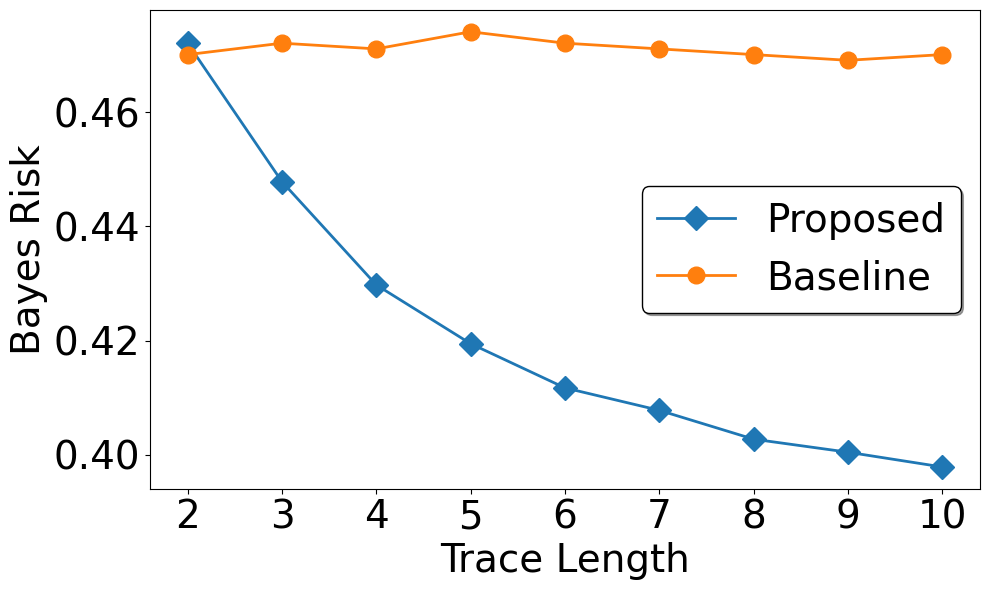

In [230]:
import matplotlib.pyplot as plt

# Example data (assuming you have these data frames ready)
epsilon_values = [2, 3, 4, 5, 6, 7, 8, 9,10]




# Define lines with linestyle added
line1 = {'x': epsilon_values, 'y': bayes_list_laplace_ln_tdrive, 'label': 'Proposed', 'color': '#1F77B4', 'marker': 'D', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
line2 = {'x': epsilon_values, 'y': bayes_list_laplace_ln_tdrive_baseline, 'label': 'Baseline', 'color': '#FF7F0E', 'marker': 'o', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
#line3 = {'x': epsilon_values, 'y': bayes_list_our_ln_tdrive, 'label': 'PSM-I$(r_b=50, \delta=5)$', 'color': '#2CA02C', 'marker': 'X', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
#line4 = {'x': epsilon_values, 'y': df_laplace_delta_ln_200_collected['Bayes security measure'], 'label': r'PLM$_{\delta}\,(\delta=5)$', 'color': '#DC143C', 'marker': '*', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}

plt.figure(figsize=(10, 6))

# Plot each line with improved settings
for line in [line1, line2]:
    plt.plot(line['x'], line['y'], label=line['label'], color=line['color'], marker=line['marker'], linestyle=line['linestyle'], linewidth=line['linewidth'], markersize=line['markersize'])

# Labels for axes
plt.xlabel('Trace Length', fontsize=28)
plt.ylabel('Bayes Risk', fontsize=28)

# Log scale for x-axis and setting specific ticks and labels
#plt.xscale('log')
plt.xticks(epsilon_values, labels=[str(val) for val in epsilon_values])
plt.tick_params(axis='both', which='major', labelsize=28)

# Adding a grid, legend, and ensuring layout is tight for best appearance
#plt.grid(True)
plt.legend(fontsize=28, frameon=True,shadow=True, loc='best').get_frame().set_edgecolor('black')

plt.tight_layout()

# Uncomment the following lines to save the plot if needed
# plt.savefig('/path/to/your/directory/filename.png', dpi=300, bbox_inches='tight')
# plt.savefig('/path/to/your/directory/filename.svg', format='svg', bbox_inches='tight')

# pathpng = r'C:\Users\ss6365\Desktop\location_privacy_final\tdrive\figure\png\tdrive_bayes_point_ln_200_tracelength.png'
# plt.savefig(pathpng, dpi=300, bbox_inches='tight')

pathsvg = r'C:\Users\ss6365\Desktop\picasso\image\svg\tdrive_bayes_point_ln_200_tracelength.svg'

plt.savefig(pathsvg, format='svg', bbox_inches='tight')
# Display the plot
plt.show()


In [222]:
bayes_list_laplace_ln_tdrive=[
 0.5034157303370786,
 0.4886292134831461,
 0.4727640449438203,
 0.46903370786516857,
 0.46319101123595496,
 0.4574831460674158,
 0.4537977528089888,
 0.4510561797752809,
 0.45213483146067424]

bayes_list_laplace_ln_tdrive_baseline=[
 0.47009072281495085,
 0.47209072281495085,
 0.47109072281495085,
 0.47409072281495085,
0.47209072281495085,
 0.47109072281495085,
 0.47009072281495085,
 0.46909072281495085,
0.47209072281495085]

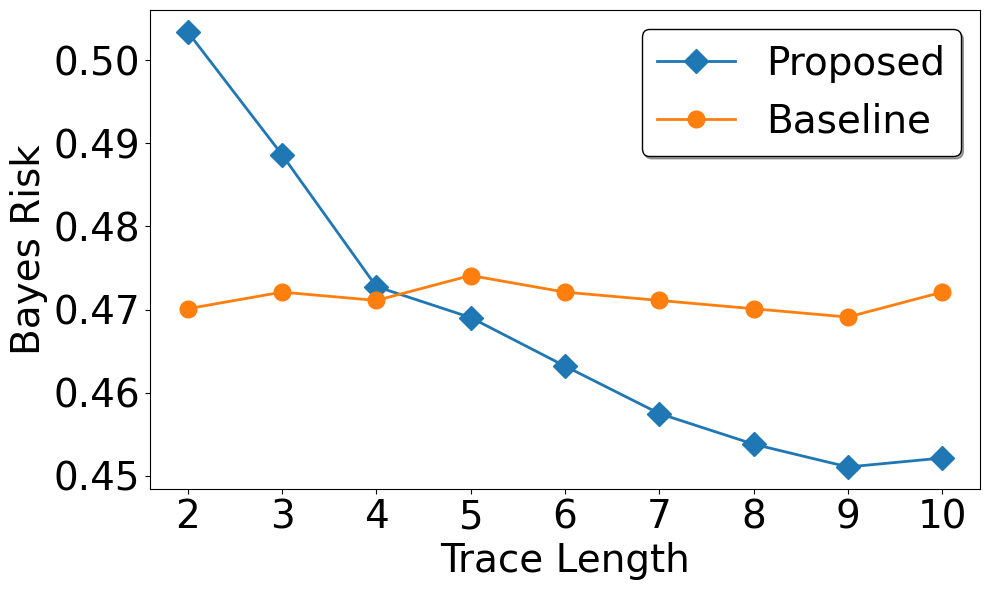

In [223]:
import matplotlib.pyplot as plt

# Example data (assuming you have these data frames ready)
epsilon_values = [2, 3, 4, 5, 6, 7, 8, 9,10]




# Define lines with linestyle added
line1 = {'x': epsilon_values, 'y': bayes_list_laplace_ln_tdrive, 'label': 'Proposed', 'color': '#1F77B4', 'marker': 'D', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
line2 = {'x': epsilon_values, 'y': bayes_list_laplace_ln_tdrive_baseline, 'label': 'Baseline', 'color': '#FF7F0E', 'marker': 'o', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
#line3 = {'x': epsilon_values, 'y': bayes_list_our_ln_tdrive, 'label': 'PSM-I$(r_b=50, \delta=5)$', 'color': '#2CA02C', 'marker': 'X', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}
#line4 = {'x': epsilon_values, 'y': df_laplace_delta_ln_200_collected['Bayes security measure'], 'label': r'PLM$_{\delta}\,(\delta=5)$', 'color': '#DC143C', 'marker': '*', 'linewidth': 2, 'markersize': 12, 'linestyle': '-'}

plt.figure(figsize=(10, 6))

# Plot each line with improved settings
for line in [line1, line2]:
    plt.plot(line['x'], line['y'], label=line['label'], color=line['color'], marker=line['marker'], linestyle=line['linestyle'], linewidth=line['linewidth'], markersize=line['markersize'])

# Labels for axes
plt.xlabel('Trace Length', fontsize=28)
plt.ylabel('Bayes Risk', fontsize=28)

# Log scale for x-axis and setting specific ticks and labels
#plt.xscale('log')
plt.xticks(epsilon_values, labels=[str(val) for val in epsilon_values])
plt.tick_params(axis='both', which='major', labelsize=28)

# Adding a grid, legend, and ensuring layout is tight for best appearance
#plt.grid(True)
plt.legend(fontsize=28, frameon=True,shadow=True, loc='best').get_frame().set_edgecolor('black')

plt.tight_layout()

# Uncomment the following lines to save the plot if needed
# plt.savefig('/path/to/your/directory/filename.png', dpi=300, bbox_inches='tight')
# plt.savefig('/path/to/your/directory/filename.svg', format='svg', bbox_inches='tight')

# pathpng = r'C:\Users\ss6365\Desktop\location_privacy_final\tdrive\figure\png\tdrive_bayes_point_ln_200_tracelength.png'
# plt.savefig(pathpng, dpi=300, bbox_inches='tight')

# pathsvg = r'C:\Users\ss6365\Desktop\location_privacy_final\tdrive\figure\svg\tdrive_bayes_point_ln_200_tracelength.svg'

#plt.savefig(pathsvg, format='svg', bbox_inches='tight')
# Display the plot
plt.show()
